In [13]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

#linear model with weight and bias: 0-dim tensors
def model(t_u, w, b):
    return w * t_u + b

#mean square loss
def loss_fn(t_p, t_c):
    sq_def = (t_p - t_c)**2
    return sq_def.mean()

#init params
w = torch.ones(())
b = torch.zeros(())

#gradient descent
'''
delta = 0.1
learning_rate = 1e-2

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / 2.0 * delta
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / 2.0 * delta

w -= learning_rate * loss_rate_of_change_w
b -= learning_rate * loss_rate_of_change_b
'''

'''
gradient of loss wrt parameters (weight and bias) = 
derivative of loss wrt weight, and derivative of loss wrt bias.

derivative of loss wrt weight (bias) =
derivative of loss wrt model * derivative of model wrt weight (bias)
'''

#derivate of loss wrt model (t_p)
def d_loss_fn_wrt_model(t_p, t_c):
    return 2 * (t_p - t_c) / t_p.size(0) #t_p.size(0) = 11, coming from mean() in loss_fn()

#derivate of model wrt weight
def d_model_wrt_w(t_u, w, b):
    return t_u

#derivate of model wrt bias
def d_model_wrt_b(t_u, w, b):
    return 1.0

# gradient of loss wrt weight and bias
def gradient_fn(t_u, t_c, t_p, w, b):
    dl_dw = d_loss_fn_wrt_model(t_p, t_c) * d_model_wrt_w(t_u, w, b)
    dl_db = d_loss_fn_wrt_model(t_p, t_c) * d_model_wrt_b(t_u, w, b)
    return torch.stack([dl_dw.sum(),dl_db.sum()])

def training_loop(n_epochs, learning_rate, params, t_c, t_u):
    for epoch in range(1, n_epochs + 1):
        w,b = params
        t_p = model(t_u, w, b)
        params -= learning_rate * gradient_fn(t_u, t_c, t_p, w, b)
        #print('epoch %d, loss %f' %(epoch, loss_fn(t_p, t_c).float()))
    return params

t_un = .1 * t_u #normalize samples
params = training_loop(n_epochs = 10000, 
              learning_rate = 1e-2, 
              params = torch.tensor([1.0, 0.0]), 
              t_c = t_c, 
              t_u = t_un)
params

tensor([  5.3676, -17.3042])

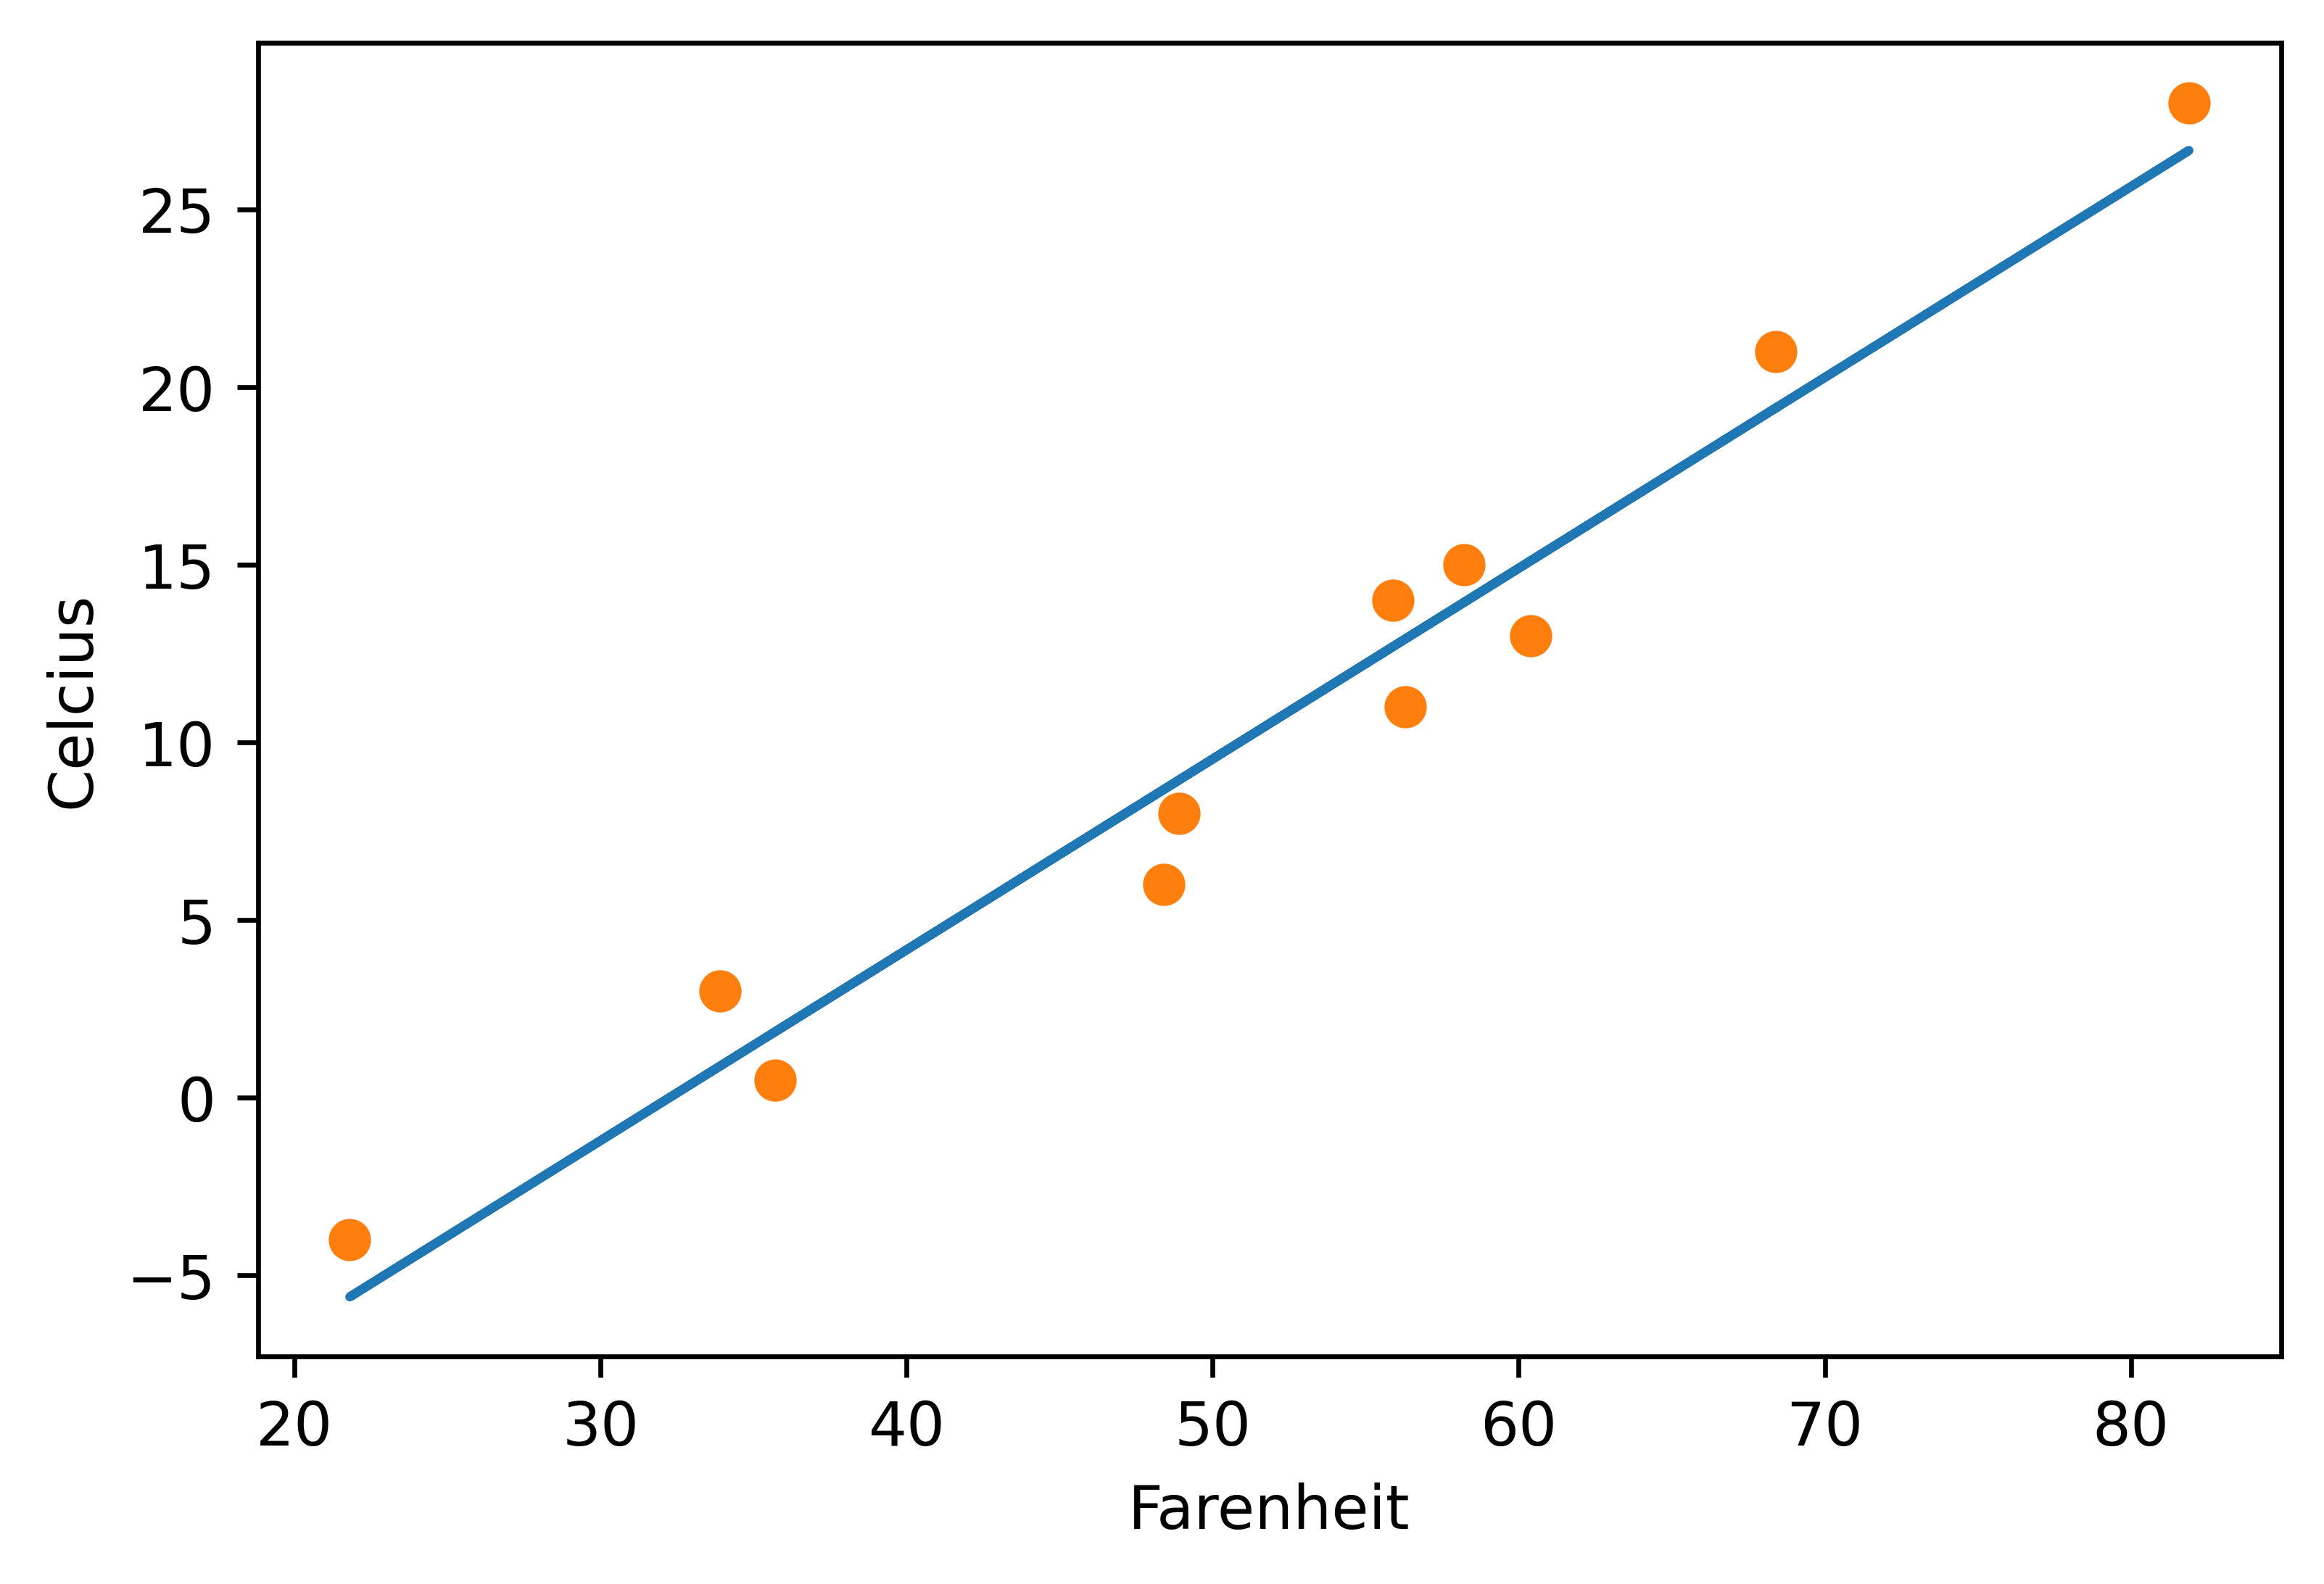

In [ ]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params) #*params unpacks it
fig = plt.figure(dpi=600)
plt.xlabel("Farenheit")
plt.ylabel("Celcius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')


In [21]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
params.grad is None #it is!

loss = loss_fn(model(t_u, *params), t_c)
loss.backward() #does backward propagation and computes gradient wrt tensor parameters whose requires_grade is on.
params.grad #derivative of loss wrt what we have in params: weight and bias
if params.grad is not None:
    params.grad.zero_()
params.grad

def training_loop_2 (n_epochs, learning_rate, params, t_c, t_u):
    for epoch in range(1 + n_epochs):
        if params.grad is not None:
            params.grad.zero_()
        loss = loss_fn(model(t_u,*params), t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        if epoch % 100000 == 0:
            print('epoch: %d, loss:%f' %(epoch, loss.float()))
    return params

training_loop_2(n_epochs = 1000000, 
                learning_rate = 1e-2, 
                params = torch.tensor([1.0, 0.0], requires_grad = True), 
                t_c = t_c, 
                t_u = t_un)

epoch: 0, loss:80.364342
epoch: 100000, loss:2.927645
epoch: 200000, loss:2.927645
epoch: 300000, loss:2.927645
epoch: 400000, loss:2.927645
epoch: 500000, loss:2.927645
epoch: 600000, loss:2.927645
epoch: 700000, loss:2.927645
epoch: 800000, loss:2.927645
epoch: 900000, loss:2.927645
epoch: 1000000, loss:2.927645


tensor([  5.3676, -17.3042], requires_grad=True)

In [ ]:
import torch.optim as optim
dir(optim)

params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr = learning_rate) 
loss = loss_fn(model(t_u,*params), t_c)
optimizer.zero_grad() #zeros params
loss.backward()
optimizer.step() #updates params using SGD strategy
params

def training_loop_3(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1+n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model(t_u, *params), t_c)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('epoch: %d, loss: %f' %(epoch, loss.float()))
    return params

params = torch.tensor([1.0,0.0], requires_grad = True)

training_loop_3(n_epochs = 5000,
                optimizer = optim.SGD([params], lr = 1e-2),
                params = params,
                t_u = t_un,
                t_c = t_c
               )

epoch: 0, loss: 80.364342
epoch: 500, loss: 7.843369
epoch: 1000, loss: 3.825483
epoch: 1500, loss: 3.091630
epoch: 2000, loss: 2.957596
epoch: 2500, loss: 2.933116
epoch: 3000, loss: 2.928646
epoch: 3500, loss: 2.927829
epoch: 4000, loss: 2.927679
epoch: 4500, loss: 2.927652
epoch: 5000, loss: 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

random_indexes = torch.randperm(n_samples)
train_indexes = random_indexes[:-n_val]
val_indexes = random_indexes[-n_val:]

train_t_u = t_u[train_indexes]
train_t_c = t_c[train_indexes]
val_t_u = t_u[val_indexes]
val_t_c = t_c[val_indexes]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

def training_loop_4(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1 + n_epochs):
        train_loss = loss_fn(model(train_t_u, *params), train_t_c)
        val_loss = loss_fn(model(val_t_u, *params), val_t_c)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

params = torch.tensor([1.0, 0.0], requires_grad = True)

training_loop_4(n_epochs = 3000,
               optimizer = optim.SGD([params], lr = 1e-2),
               params = params,
               train_t_u = train_t_un,
               train_t_c = train_t_c,
               val_t_u = val_t_un,
               val_t_c = val_t_c)

Epoch 0, Training loss 81.0008, Validation loss 77.5003
Epoch 1, Training loss 43.3337, Validation loss 20.9351
Epoch 2, Training loss 36.9531, Validation loss 8.1371
Epoch 3, Training loss 35.7791, Validation loss 4.6260
Epoch 500, Training loss 7.2985, Validation loss 2.3732
Epoch 1000, Training loss 3.7024, Validation loss 2.2571
Epoch 1500, Training loss 3.2515, Validation loss 2.2199
Epoch 2000, Training loss 3.1949, Validation loss 2.2072
Epoch 2500, Training loss 3.1878, Validation loss 2.2028
Epoch 3000, Training loss 3.1869, Validation loss 2.2012


tensor([  5.3077, -17.2600], requires_grad=True)

Epoch 0, Training loss 700.2715, Validation loss 565.6469
Epoch 1, Training loss 413.4339, Validation loss 317.2715
Epoch 2, Training loss 246.8865, Validation loss 175.8800
Epoch 3, Training loss 150.1815, Validation loss 95.9354
Epoch 500, Training loss 11.8089, Validation loss 2.7349
Epoch 1000, Training loss 8.7526, Validation loss 3.7803
Epoch 1500, Training loss 6.6933, Validation loss 4.7656
Epoch 2000, Training loss 5.3055, Validation loss 5.6595
Epoch 2500, Training loss 4.3700, Validation loss 6.4499
Epoch 3000, Training loss 3.7390, Validation loss 7.1365
Epoch 3500, Training loss 3.3132, Validation loss 7.7250
Epoch 4000, Training loss 3.0255, Validation loss 8.2243
Epoch 4500, Training loss 2.8309, Validation loss 8.6447
Epoch 5000, Training loss 2.6989, Validation loss 8.9965
Epoch 5500, Training loss 2.6092, Validation loss 9.2892
Epoch 6000, Training loss 2.5479, Validation loss 9.5317
Epoch 6500, Training loss 2.5058, Validation loss 9.7319
Epoch 7000, Training loss 2.

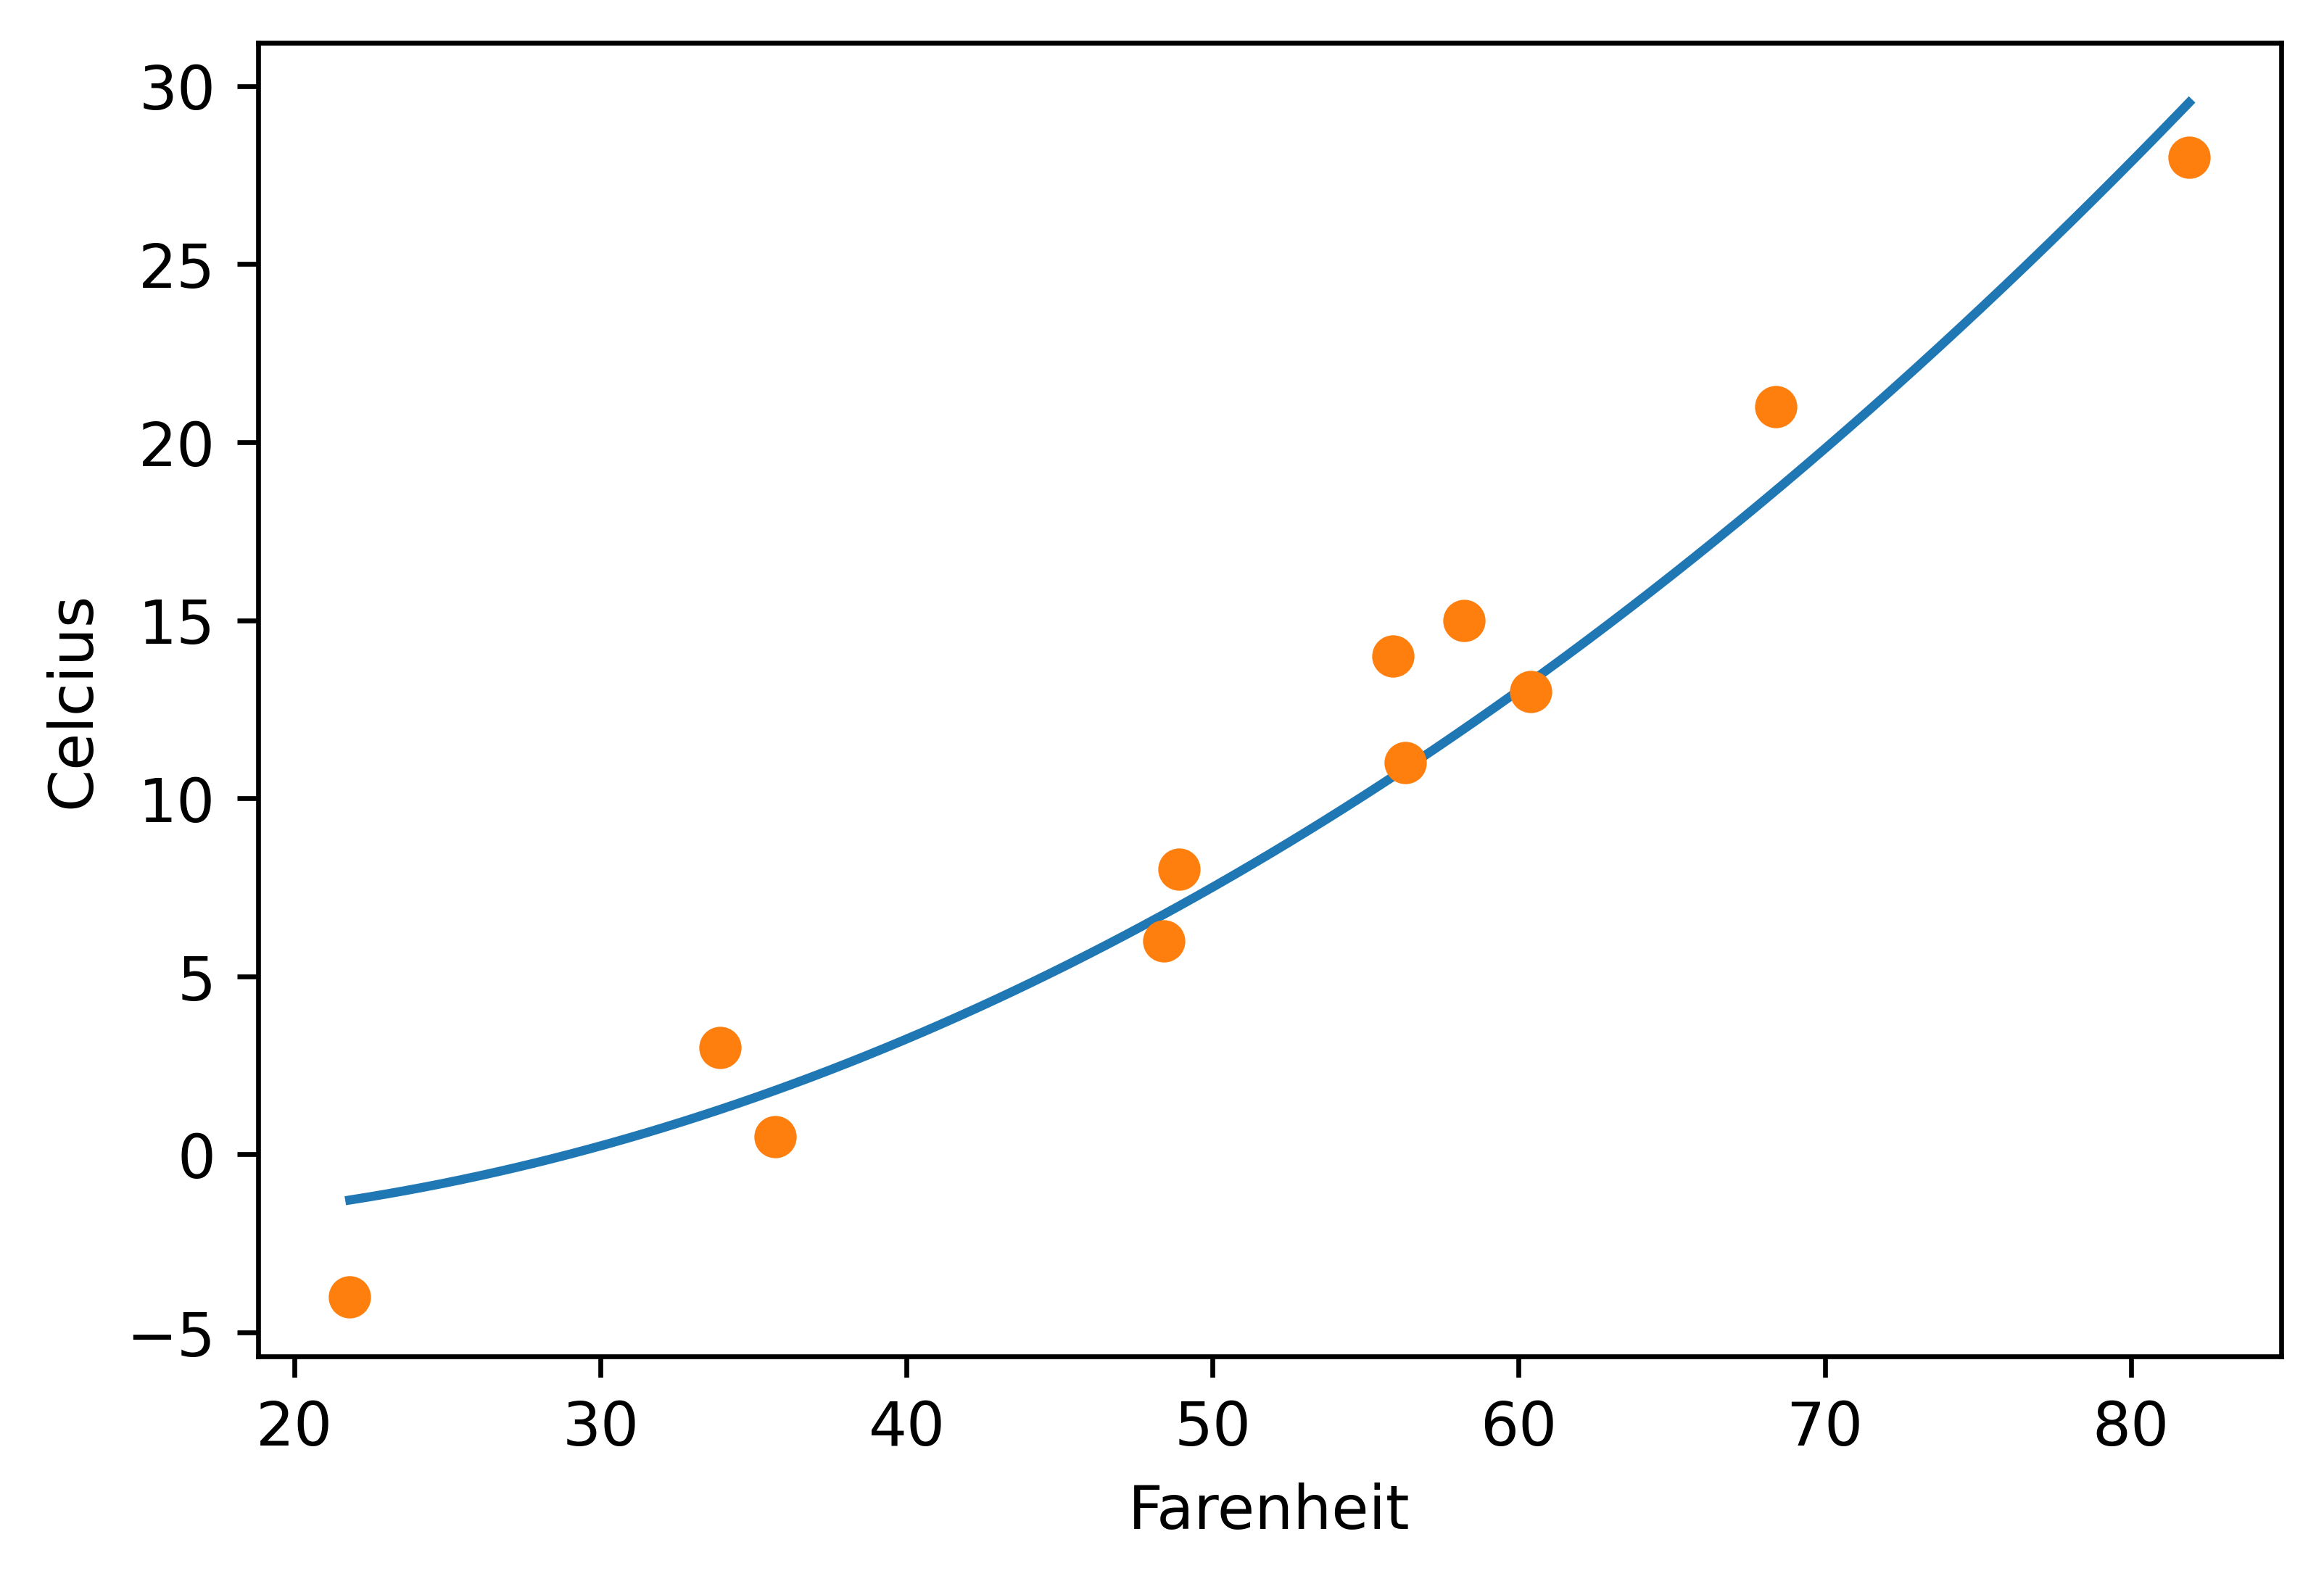

In [20]:
#change model: w2 * t_u ** 2 + w1 * t_u + b

def model_2(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

#training the same except to call model_2()
def training_loop_5(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1 + n_epochs):
        train_loss = loss_fn(model_2(train_t_u, *params), train_t_c)
        val_loss = loss_fn(model_2(val_t_u, *params), val_t_c)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

#initial params change
params = torch.tensor([1.0,1.0,0.0], requires_grad = True)

params = training_loop_5(n_epochs = 10000,
               optimizer = optim.SGD([params], lr = 1e-4),
               params = params,
               train_t_u = train_t_un,
               train_t_c = train_t_c,
               val_t_u = val_t_un,
               val_t_c = val_t_c)


#plot the curve
from scipy.interpolate import interp1d

import numpy as np

t_p = model_2(t_un, *params)

cubic_interploation_model = interp1d(t_u.numpy(), t_p.detach().numpy(), kind = "cubic")
X_ = np.linspace(t_u.numpy().min(), t_u.numpy().max(), 500)
Y_ = cubic_interploation_model(X_)

fig = plt.figure(dpi=600)
plt.xlabel("Farenheit")
plt.ylabel("Celcius")
plt.plot(X_, Y_)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')